In [255]:
from notebook_utils import setup, load_tweet_df

setup()

In [ ]:
import pandas as pd
from data_tools import load_crawled_terms, load_parsed_data

crawled_terms = load_crawled_terms("../keywords-3nov.txt")

tweet_df = load_parsed_data('../data/14-nov/parsed_tweets.json', include_cols={
    "datastore_id",
    "timestamp",
    "retweet_count",
    "quote_count",
    "quote_tweet"
}.union(crawled_terms), verbose=True, index_col="datastore_id")
recent_tweet_df = tweet_df[tweet_df.timestamp > '2020-10-23 00:00:00']
tweet_df.info()

In [257]:
# Prepare crawled terms dataframe

crawled_terms_stats = []

for term in crawled_terms:
    if term in recent_tweet_df.columns:
        stats = {}
        stats["term"] = term
        stats["tweet count"] = recent_tweet_df[term].value_counts().values[0]
        crawled_terms_stats.append(stats)

crawled_terms_df = pd.DataFrame(crawled_terms_stats).sort_values(by=['tweet count'], ascending=False)

In [ ]:
retweet_df = load_parsed_data('../data/14-nov/parsed_retweets.json')

retweet_df.info()

In [ ]:
retweet_df_by_tweet = retweet_df.set_index("retweeted")

# How complete is our retweet graph?

Method: sampling N tweets from our dataset and checking how many retweets we have crawled

In [ ]:
def sample_retweet_coverage(tweet_df, N_samples, min_retweet_count=5):
    filtered_tweets = tweet_df[tweet_df["retweet_count"] > min_retweet_count]
    if (filtered_tweets.shape[0] == 0):
        filtered_tweets = tweet_df[tweet_df["retweet_count"] > 1]

    if (N_samples > filtered_tweets.shape[0]):
        N_samples = filtered_tweets.shape[0]

    if (N_samples == 0):
        return None, 0, 0
    
    sampled_tweets = filtered_tweets.sample(N_samples)
    retweet_coverage_stats = []

    i = 0
    for tweet_id, tweet in sampled_tweets.iterrows():
        stats = {}
        crawled_retweet_count = len(retweet_df_by_tweet.loc[tweet_id])

        stats["tweet_id"] = tweet_id
        stats["timestamp"] = tweet["timestamp"]
        stats["metadata_retweet_count"] = tweet["retweet_count"]
        stats["crawled_retweet_count"] = crawled_retweet_count

        retweet_coverage_stats.append(stats)

        i += 1
        if (i % 50 == 0):
            print("Processed {}/{} samples".format(i, N_samples))

    retweet_coverage_stats_df = pd.DataFrame(retweet_coverage_stats).sort_values('metadata_retweet_count', ascending=False)

    aggregated_metadata_retweet_count = retweet_coverage_stats_df["metadata_retweet_count"].sum()
    aggregated_crawled_retweet_count = retweet_coverage_stats_df["crawled_retweet_count"].sum()

    return retweet_coverage_stats_df, aggregated_metadata_retweet_count, aggregated_crawled_retweet_count

In [ ]:
retweet_coverage_stats_df, aggregated_metadata_retweet_count, aggregated_crawled_retweet_count = sample_retweet_coverage(recent_tweet_df, 1000)

## Broken down by each crawled term


In [ ]:
# NB, N_samples=1000 takes ~1 hour to run
N_samples = 1000

retweet_coverage_by_term = {}

for crawled_term in crawled_terms_df["term"]:
    if (crawled_term in recent_tweet_df):
        tweet_df_filtered_by_term = recent_tweet_df[recent_tweet_df[crawled_term] == 1]
        print("Term: {} ({} total tweets)".format(crawled_term, tweet_df_filtered_by_term.shape[0]))
        coverage_df, aggregated_metadata_retweet_count, aggregated_crawled_retweet_count = sample_retweet_coverage(tweet_df_filtered_by_term, N_samples)

        if (coverage_df is not None):
            print("Retweet coverage for {} samples: {:,.1f}% ({}/{})".format(
                N_samples,
                (aggregated_crawled_retweet_count / aggregated_metadata_retweet_count) * 100,
                aggregated_crawled_retweet_count,
                aggregated_metadata_retweet_count
            ))
            retweet_coverage_by_term[crawled_term] = {
                "coverage_df": coverage_df,
                "aggregated_metadata_retweet_count": aggregated_metadata_retweet_count,
                "aggregated_crawled_retweet_count": aggregated_crawled_retweet_count
            }
        else:
            print("No tweets with retweets")
        print()

In [ ]:
combined_coverage = {}

for term, term_coverage in retweet_coverage_by_term.items():
    for tweet_id, tweet_stats in term_coverage["coverage_df"].iterrows():
        tweet_id = tweet_stats["tweet_id"]
        if tweet_id not in combined_coverage:
            combined_coverage[tweet_id] = tweet_stats
        combined_coverage[tweet_id]["term"] = term

combined_coverage_df = pd.DataFrame(combined_coverage.values()).reset_index()

In [268]:
# Load from csv
combined_coverage_df = pd.read_csv("./data_export/combined_coverage_df.csv")
combined_coverage_df

,tweet_id,timestamp,metadata_retweet_count,crawled_retweet_count,term
0,1324717483987709954,2020-11-06T14:17:14Z,19759,4485,voter fraud
1,1324740564227686402,2020-11-06T15:48:57Z,13903,2970,voter fraud
2,1326594925593567234,2020-11-11T18:37:31Z,12894,3768,voter fraud
3,1324086834482290692,2020-11-04T20:31:16Z,11102,2778,voter fraud
4,1325973934244827137,2020-11-10T01:29:55Z,7907,2256,voter fraud
...,...,...,...,...,...
10083,1325108366369300487,2020-11-07T16:10:28Z,2,3,#ilhanomarballotharvesting
10084,1320145143228293122,2020-10-24T23:28:23Z,268,246,#votebymailfraud
10085,1320503900873523201,2020-10-25T23:13:58Z,101,45,#votebymailfraud
10086,1324302106141089796,2020-11-05T10:46:41Z,64,27,#nomailinvoting


In [269]:
aggregated_metadata_retweet_count = combined_coverage_df["metadata_retweet_count"].sum()
aggregated_crawled_retweet_count = combined_coverage_df["crawled_retweet_count"].sum()

print("Across all terms")
print("Retweet coverage for {:,} samples: {:,.1f}% ({}/{})".format(
    combined_coverage_df.shape[0],
    (aggregated_crawled_retweet_count / aggregated_metadata_retweet_count) * 100,
    aggregated_crawled_retweet_count,
    aggregated_metadata_retweet_count
))


print()
print("...for each tweet (top 25)")

for i, tweet in combined_coverage_df[:25].iterrows():
    print("[{} tweeted at {}]: {:,.1f}% ({} / {})".format(
        tweet["tweet_id"],
        tweet["timestamp"],
        tweet["crawled_retweet_count"] / tweet["metadata_retweet_count"] * 100,
        tweet["crawled_retweet_count"],
        tweet["metadata_retweet_count"]
    ))

Across all terms
Retweet coverage for 10,088 samples: 41.5% (629606/1516970)

...for each tweet (top 25)
[1324717483987709954 tweeted at 2020-11-06T14:17:14Z]: 22.7% (4485 / 19759)
[1324740564227686402 tweeted at 2020-11-06T15:48:57Z]: 21.4% (2970 / 13903)
[1326594925593567234 tweeted at 2020-11-11T18:37:31Z]: 29.2% (3768 / 12894)
[1324086834482290692 tweeted at 2020-11-04T20:31:16Z]: 25.0% (2778 / 11102)
[1325973934244827137 tweeted at 2020-11-10T01:29:55Z]: 28.5% (2256 / 7907)
[1325130416890683399 tweeted at 2020-11-07T17:38:05Z]: 29.4% (2293 / 7808)
[1324239164057989120 tweeted at 2020-11-05T06:36:34Z]: 46.2% (3411 / 7385)
[1326146122658746370 tweeted at 2020-11-10T12:54:08Z]: 31.0% (2268 / 7315)
[1324628241982828544 tweeted at 2020-11-06T08:22:37Z]: 41.0% (2521 / 6143)
[1326359587562409985 tweeted at 2020-11-11T03:02:22Z]: 38.1% (2312 / 6075)
[1324468618789347328 tweeted at 2020-11-05T21:48:20Z]: 11.7% (598 / 5128)
[1326674206675841026 tweeted at 2020-11-11T23:52:33Z]: 46.7% (2035 

In [267]:
combined_coverage_df.to_csv("./data_export/combined_coverage_df.csv", index=False)

## Plots

In [282]:
import matplotlib.pyplot as plt

print(combined_coverage_df.columns)
# Prepare data
plot_df = combined_coverage_df.drop('tweet_id', axis=1).groupby("term").sum().sort_values("metadata_retweet_count", ascending=False)
plot_df["percentage"] = ((plot_df["crawled_retweet_count"] / plot_df["metadata_retweet_count"]) * 100).round(2)
plot_df

Index(['tweet_id', 'timestamp', 'metadata_retweet_count',
       'crawled_retweet_count', 'term'],
      dtype='object')


,metadata_retweet_count,crawled_retweet_count,percentage
term,,,
ballot harvesting,224052,90406,40.35
voter fraud,223233,87451,39.17
election interference,219400,82807,37.74
election fraud,185836,72817,39.18
ballot fraud,161661,64041,39.61
#voterfraud,109466,46359,42.35
#stopthesteal,91376,41553,45.47
stolen ballots,59485,21077,35.43
#electionfraud,53369,24755,46.38


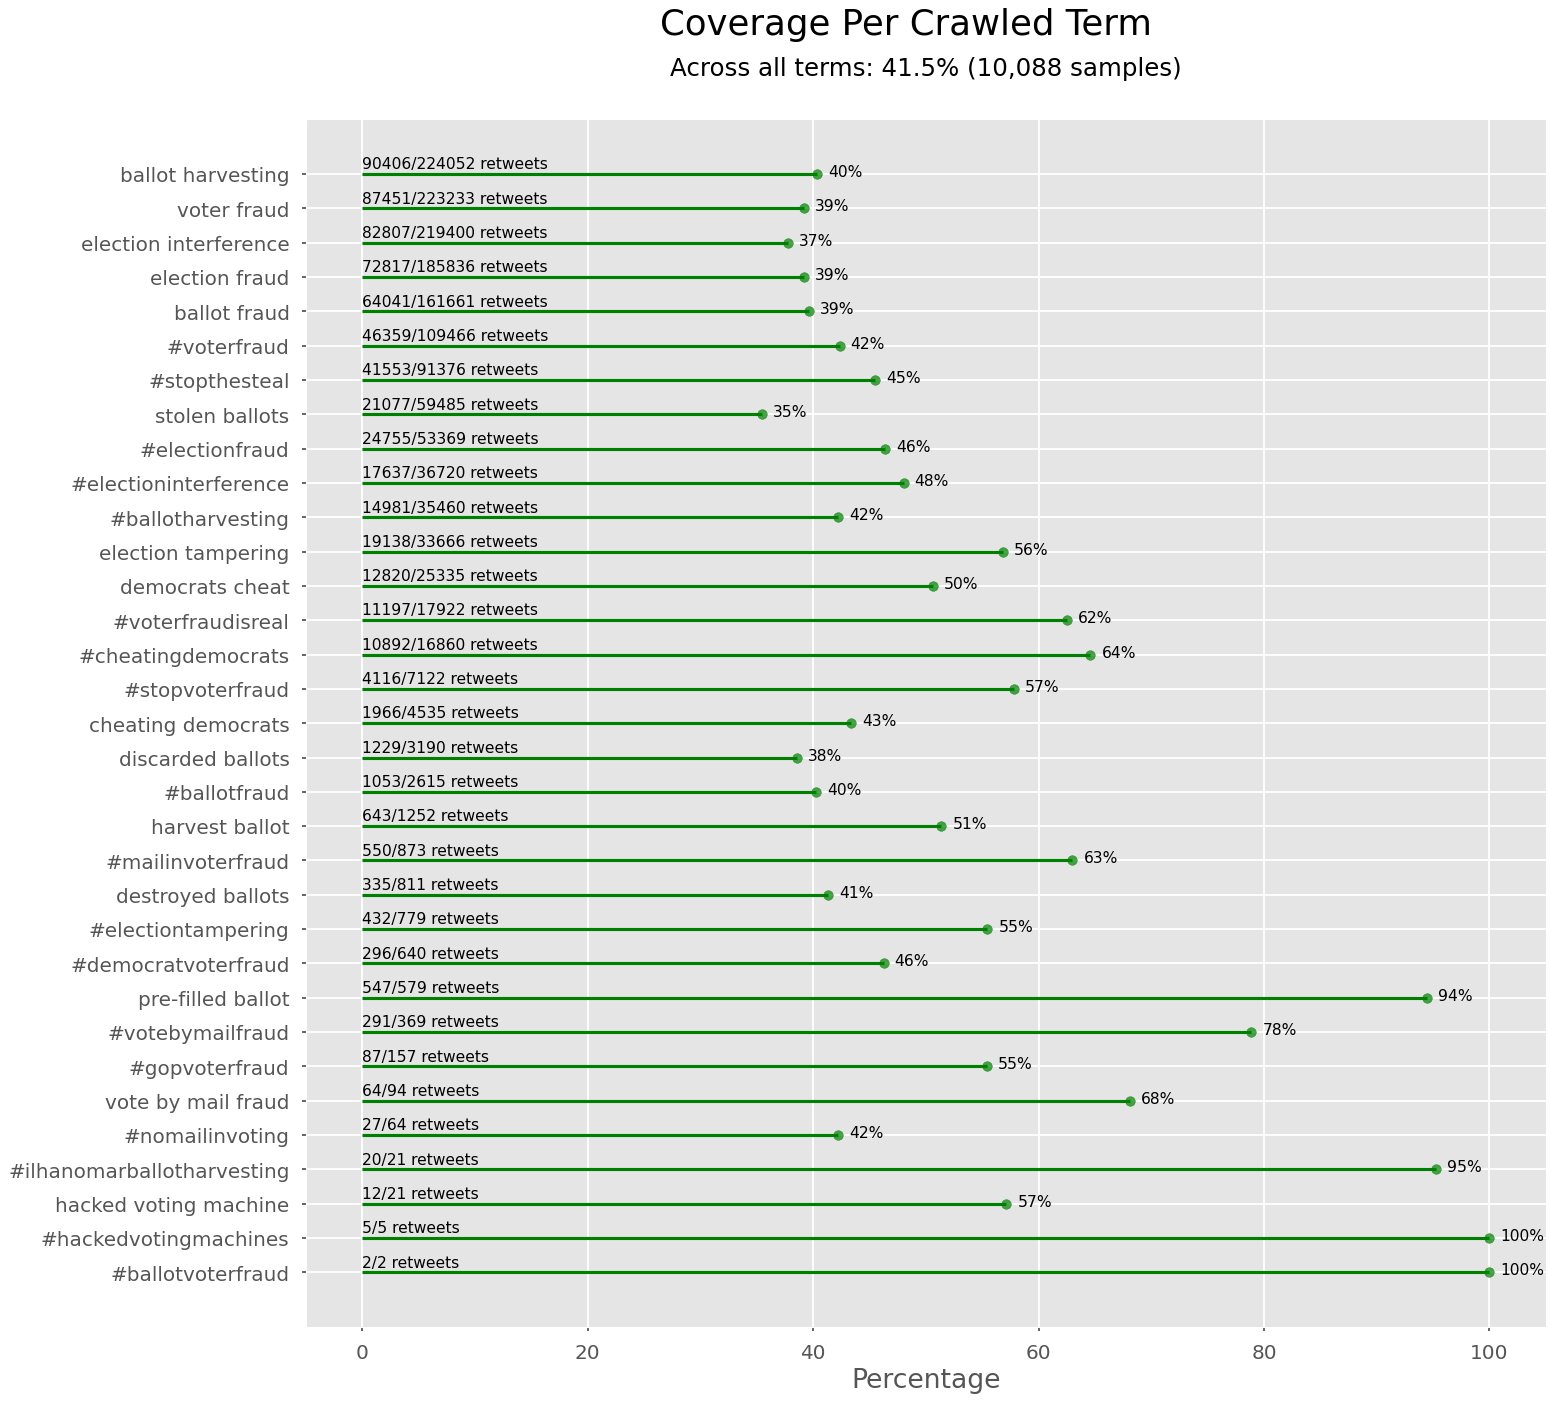

In [283]:
import numpy as np
# Plot top 20 terms
TOP_N = 20

labels = plot_df.index.values
percentage_values = plot_df["percentage"].values

x = np.flip(percentage_values)
y = np.flip(labels)

fig, ax = plt.subplots(figsize=(20,20), dpi=80)
ax.hlines(y=y, xmin=0, xmax=x, color='green')
ax.scatter(x=x, y=y, s=75, color='green', alpha=0.7)

for i, txt in enumerate(x):
    df_row = plot_df.iloc[-i - 1]
    label = "{}/{} retweets".format(int(df_row["crawled_retweet_count"]), int(df_row["metadata_retweet_count"]))
    ax.annotate(label, xy=(0, y[i]), textcoords='offset points', xytext=(0, 5), fontsize=14)
    ax.annotate("{}%".format(int(x[i])), xy=(x[i], y[i]), textcoords='offset points', xytext=(10, -2), fontsize=14)

ax.tick_params(axis='both', labelsize=18)

subtitle = "Across all terms: {:,.1f}% ({:,} samples)".format(
    (aggregated_crawled_retweet_count / aggregated_metadata_retweet_count) * 100,
    combined_coverage_df.shape[0]
)

fig.suptitle('Coverage Per Crawled Term', fontsize=32, y=0.95)
ax.set_title(subtitle, pad=40, fontsize=22)
ax.set_xlabel('Percentage', fontsize=24)
plt.show()


# How complete is our quote graph?

In [ ]:
import pandas as pd
N = 200
sampled_tweets = recent_tweet_df[recent_tweet_df["quote_count"] > 5].sample(N)
quoted_id_df = recent_tweet_df["quote_tweet"]
quote_coverage_stats = []

for tweet_id, tweet in sampled_tweets.iterrows():
    stats = {}
    crawled_quote_count = 0

    for i, quoted_tweet_id in quoted_id_df.iteritems():
        if quoted_tweet_id == tweet_id:
            crawled_quote_count += 1

    stats["tweet_id"] = tweet_id
    stats["timestamp"] = tweet["timestamp"]
    stats["metadata_quote_count"] = tweet["quote_count"]
    stats["crawled_quote_count"] = crawled_quote_count

    quote_coverage_stats.append(stats)

quote_coverage_stats_df = pd.DataFrame(quote_coverage_stats).sort_values('metadata_quote_count', ascending=False)

aggregated_metadata_quote_count = quote_coverage_stats_df["metadata_quote_count"].sum()
aggregated_crawled_quote_count = quote_coverage_stats_df["crawled_quote_count"].sum()

print("Quote coverage for {} samples: {:,.1f}% ({}/{})".format(
    N,
    (aggregated_crawled_quote_count / aggregated_metadata_quote_count) * 100,
    aggregated_crawled_quote_count,
    aggregated_metadata_quote_count
))

print("...for each tweet")

for i, tweet in quote_coverage_stats_df.iterrows():
    print("[{} tweeted at {}]: {:,.1f}% ({} / {})".format(
        tweet["tweet_id"],
        tweet["timestamp"],
        tweet["crawled_quote_count"] / tweet["metadata_quote_count"] * 100,
        tweet["crawled_quote_count"],
        tweet["metadata_quote_count"]
    ))

# How complete is our retweet count?

Method: sampling 100 tweets from our datastore and comparing their retweet count with their retweet count according to the Twitter API.